# Signal and Image Processing: Homework 5
## Patomporn Payoungkhamdee 6138171

### Problem
A signal stored in the ASCII file data.txtwas corrupted withsingle-frequency noisewhose frequency is unknown.We want to apply a notch filter to remove this noise.The sampling frequency of this signal is 1 kHz

In [1]:
# Settings
FS = 1000.0
T = 1.0/FS

In [2]:
# Dependency
import typing
import math
import pandas as pd
import numpy as np
from scipy import fftpack
from scipy.signal import unit_impulse, filtfilt

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

### 1) Visualize

Text(0.5, 0, 'Sampling step')

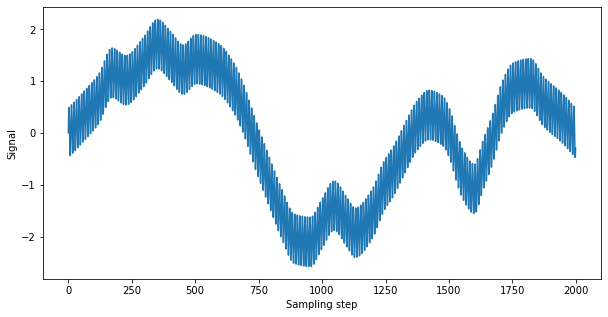

In [3]:
%matplotlib inline
df = pd.read_csv("data.txt", header=None)
data = df[0].values
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data, "-")
ax.set_ylabel("Signal")
ax.set_xlabel("Sampling step")

### 2) Compute and plot the magnitude spectrum of the signal to determine the noise frequency

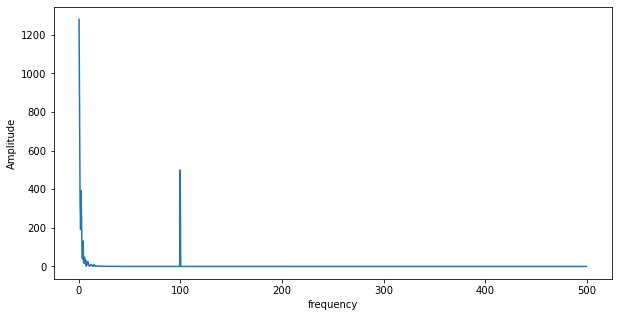

In [4]:
df = pd.read_csv("data.txt", header=None)
signal = df[0].values
N = len(signal)

fft_signal = fftpack.fft(signal)
norm_fft_signal = np.abs(fft_signal)
freqs = fftpack.fftfreq(N, T)
i = freqs > 0

plt.figure(figsize=(10,5))
plt.ylabel('Amplitude')
plt.xlabel('frequency')
plt.plot(freqs[i], norm_fft_signal[i])

It's obvious to say that noise frequency is 100 Hz

### 3) Use a notch filter with $\Delta(F) = 10 Hz$ to remove the noise

### 3.1) Transfer function

\begin{align}
H_\text{notch} (z) = \frac{
    b_0[1-2\cos(\theta_0)z^{-1}+z^{-2}]
}{
    1 - 2r\cos(\theta_0)z^{-1}+r^2z^{-2}
}
\end{align}


### 3.2) Compute and plot the magnitude response of the notch filter

In [5]:
df = pd.read_csv("data.txt", header=None)
signal = df[0].values
N = len(signal)

fft_signal = fftpack.fft(signal)
norm_fft_signal = np.abs(fft_signal)
freqs = fftpack.fftfreq(N, T)
i_positives = freqs > 0

F0 = 100.0
deltaF = 10.0
r = 1.0 - math.pi * F0 / FS

theta_0 = 2.0 * math.pi * F0 / FS
r = 1.0 - math.pi * deltaF / FS
b_0 = np.abs(1.0 + 2.0 * r * np.cos(theta_0) + r**2.0) / (2.0 * np.abs(1.0 + np.cos(theta_0)))

def get_freq_response(f, _theta_0 = theta_0, _r = r, _b_0 = b_0, _T = 1/FS):
    z = np.exp(complex(0, 2.0*math.pi*f*_T))
    def get_notch_filter(_z, _theta_0 = theta_0, _r = r, _b_0 = b_0):
        return np.multiply(
            _b_0,
            np.divide(
                1.0 - 2.0 * np.cos(_theta_0) * np.power(_z, -1.0) + np.power(_z, -2.0),
                1.0 - 2.0 * _r * np.cos(_theta_0) * np.power(_z, -1.0) + np.power(_r, 2.0) * np.power(_z, -2.0)
            )
        )
    return np.abs(get_notch_filter(z, _theta_0 = theta_0, _r = r, _b_0 = b_0))        

Text(0.5, 0, 'Frequency')

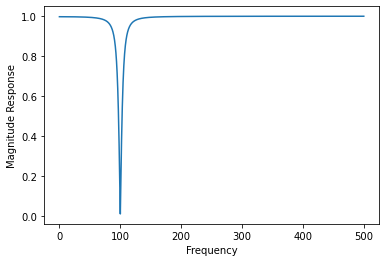

In [6]:
f_space = np.linspace(0.0, FS/2.0, N)
# magnitude_response = np.subtract(1.0, unit_impulse(N, int(F0)))
magnitude_response = [get_freq_response(_f) for _f in f_space]
plt.plot(f_space, magnitude_response)
plt.ylabel('Magnitude Response')
plt.xlabel('Frequency')

### 3.3) Difference equation corresponding to this notch filter

From

\begin{align}
H_\text{notch} (z) = \frac{
    b_0[1-2\cos(\theta_0)z^{-1}+z^{-2}]
}{
    1 - 2r\cos(\theta_0)z^{-1}+r^2z^{-2}
}
\end{align}

will gives

\begin{align}
y(k) = b_0x(k) - 2b_0\cos(\theta_0)x(k-1) + b_)x(k-2) + 2r\cos(\theta_0)y(k-1) - r^2y(k-2)
\end{align}

### 3.3) Apply the notch filter to the signal using the difference equation

Text(0.5, 0, 'Sampling step')

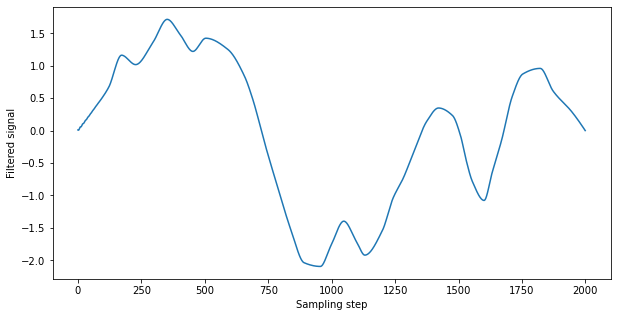

In [7]:
vec_b = [b_0, -2.0 * b_0 * np.cos(theta_0), b_0]
vec_a = [1.0, -2.0 * r * np.cos(theta_0), r**2.0]
def get_filtered_y(
        x: typing.List[float], y: typing.List[float],
        k: int, _vec_b: float = vec_b, _vec_a: float = vec_a
    ) -> float:
    m = len(_vec_b) - 1
    vec_input = []
    for i in range(m+1):
        try:
            vec_input.append(_vec_b[i]*x[k-i])
        except IndexError:
            pass
    n = len(_vec_a)
    vec_output = []
    for i in range(1, n+1):
        try:
            vec_output.append(_vec_a[i]*y[k-i])
        except IndexError:
            pass
    return sum(vec_input) - sum(vec_output)
filtered_signal = []
for k in range(N):
    filtered_signal_k = get_filtered_y(
        x = signal, y = filtered_signal, k = k
    )
    filtered_signal.append(filtered_signal_k)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(filtered_signal, "-")
ax.set_ylabel('Filtered signal')
ax.set_xlabel('Sampling step')

### 3.5) Apply the notch filter to the signal in the frequency domain

Text(0.5, 0, 'Sampling step')

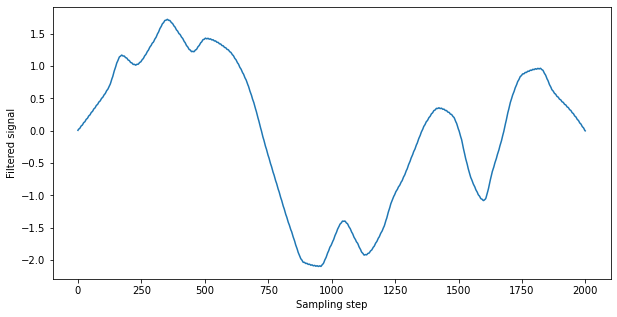

In [15]:
X = fftpack.rfft(signal)
Y = np.multiply(magnitude_response, X)
y = fftpack.irfft(Y)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(y, "-")
ax.set_ylabel('Filtered signal')
ax.set_xlabel('Sampling step')

For some reason, I still could not verify this method.

### 3.6) Apply the notch filter to the signal using the function filter

Text(0.5, 0, 'Sampling step')

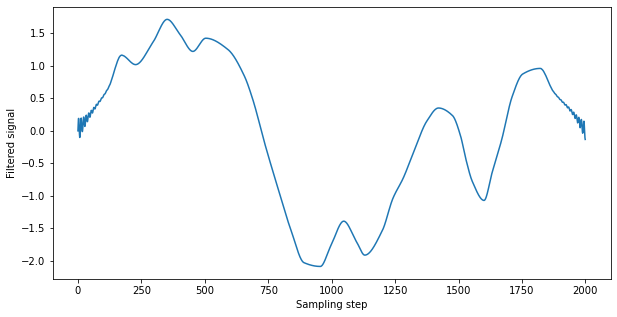

In [9]:
y = filtfilt(vec_b, vec_a, signal)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(y, "-")
ax.set_ylabel('Filtered signal')
ax.set_xlabel('Sampling step')

Even 3.4) make me sad but now I could use filter in the python calling "filtfilt" in "scipy.signal"